<a href="https://colab.research.google.com/github/kiboiWanjohi/scotep-kenya/blob/main/histopathology/kaggle_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copied from Basel Anaya - Cesar Pereiro Garcia

Pre-requisites and Dependencies

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp /content/drive/MyDrive/Stat_Docs/kaggle.json ~/.kaggle/kaggle.json

In [5]:
# Change permission
! chmod 600 ~/.kaggle/kaggle.json

## Dataset Download

Link to dataset --

In [6]:
! kaggle datasets download paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:

# unzip content
! unzip /content/breast-histopathology-images.zip -d /content/breast-histopathology-images

Archive:  /content/breast-histopathology-images.zip
replace /content/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# check disk usage
! df -h

In [9]:
! pip install plotly
! pip install seaborn

In [10]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread
import tensorflow.keras as keras
import tensorflow as tf

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [11]:
# path file and list to contain breast images
path = '/content/breast-histopathology-images'
breast_imgs=[]

In [12]:
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.png'):
            breast_imgs.append(os.path.join(root, file))



In [13]:
# empty lists for information
patient_numbers = []
cancer_status = []
x_coords = []
y_coords = []
file_names = []
file_paths = []

In [14]:
for img in breast_imgs:
    parts = img.split('/') # /content/breast-histopathology-images/10264/1/10264_idx5_x1601_y1451_class1.png becomes: parts = ['content', 'breast-histopathology-images', '10264', '1', '10264_idx5_x1601_y1451_class1.png']
    filename = parts[-1] #last component of the split path, which is the filename
    patient_number = parts[-3] #hird-to-last component of the path, which corresponds to the patient number.
    info = filename.rstrip('.png').split('_') #Removes the .png extension from the filename using .rstrip('.png').Splits the remaining part of the filename into components using '_' as the delimiter.Example: ['10264', 'idx5', 'x1601', 'y1451', 'class1'].
    x_coord = int(info[2][1:]) #Extracts the third element ('x1601'), removes the leading 'x' using slicing ([1:]), and converts it to an integer.
    y_coord = int(info[3][1:]) #Extracts the fourth element ('y1451'), removes the leading 'y' using slicing ([1:]), and converts it to an integer.
    status = int(info[4][-1]) #Extracts the last element ('class1'), gets the last character ([-1]), and converts it to an integer.
    patient_numbers.append(patient_number)
    cancer_status.append(status)
    x_coords.append(x_coord)
    y_coords.append(y_coord)
    file_names.append(filename)
    file_paths.append(img)


In [15]:
df = pd.DataFrame({
    'Patient_Number': patient_numbers,
    'Cancer_Status': cancer_status,
    'X_Coord': x_coords,
    'Y_Coord': y_coords,
    'File_Name': file_names,
    'File_Path': file_paths
})

df.sort_values(by=['Patient_Number', 'X_Coord', 'Y_Coord'], inplace=True)

print(df.head())


       Patient_Number  Cancer_Status  X_Coord  Y_Coord  \
271721          10253              0      151     1551   
547919          10253              0      151     1551   
271932          10253              0      201     1551   
548130          10253              0      201     1551   
271841          10253              0      301     1651   

                               File_Name  \
271721  10253_idx5_x151_y1551_class0.png   
547919  10253_idx5_x151_y1551_class0.png   
271932  10253_idx5_x201_y1551_class0.png   
548130  10253_idx5_x201_y1551_class0.png   
271841  10253_idx5_x301_y1651_class0.png   

                                                File_Path  
271721  /content/breast-histopathology-images/10253/0/...  
547919  /content/breast-histopathology-images/IDC_regu...  
271932  /content/breast-histopathology-images/10253/0/...  
548130  /content/breast-histopathology-images/IDC_regu...  
271841  /content/breast-histopathology-images/10253/0/...  


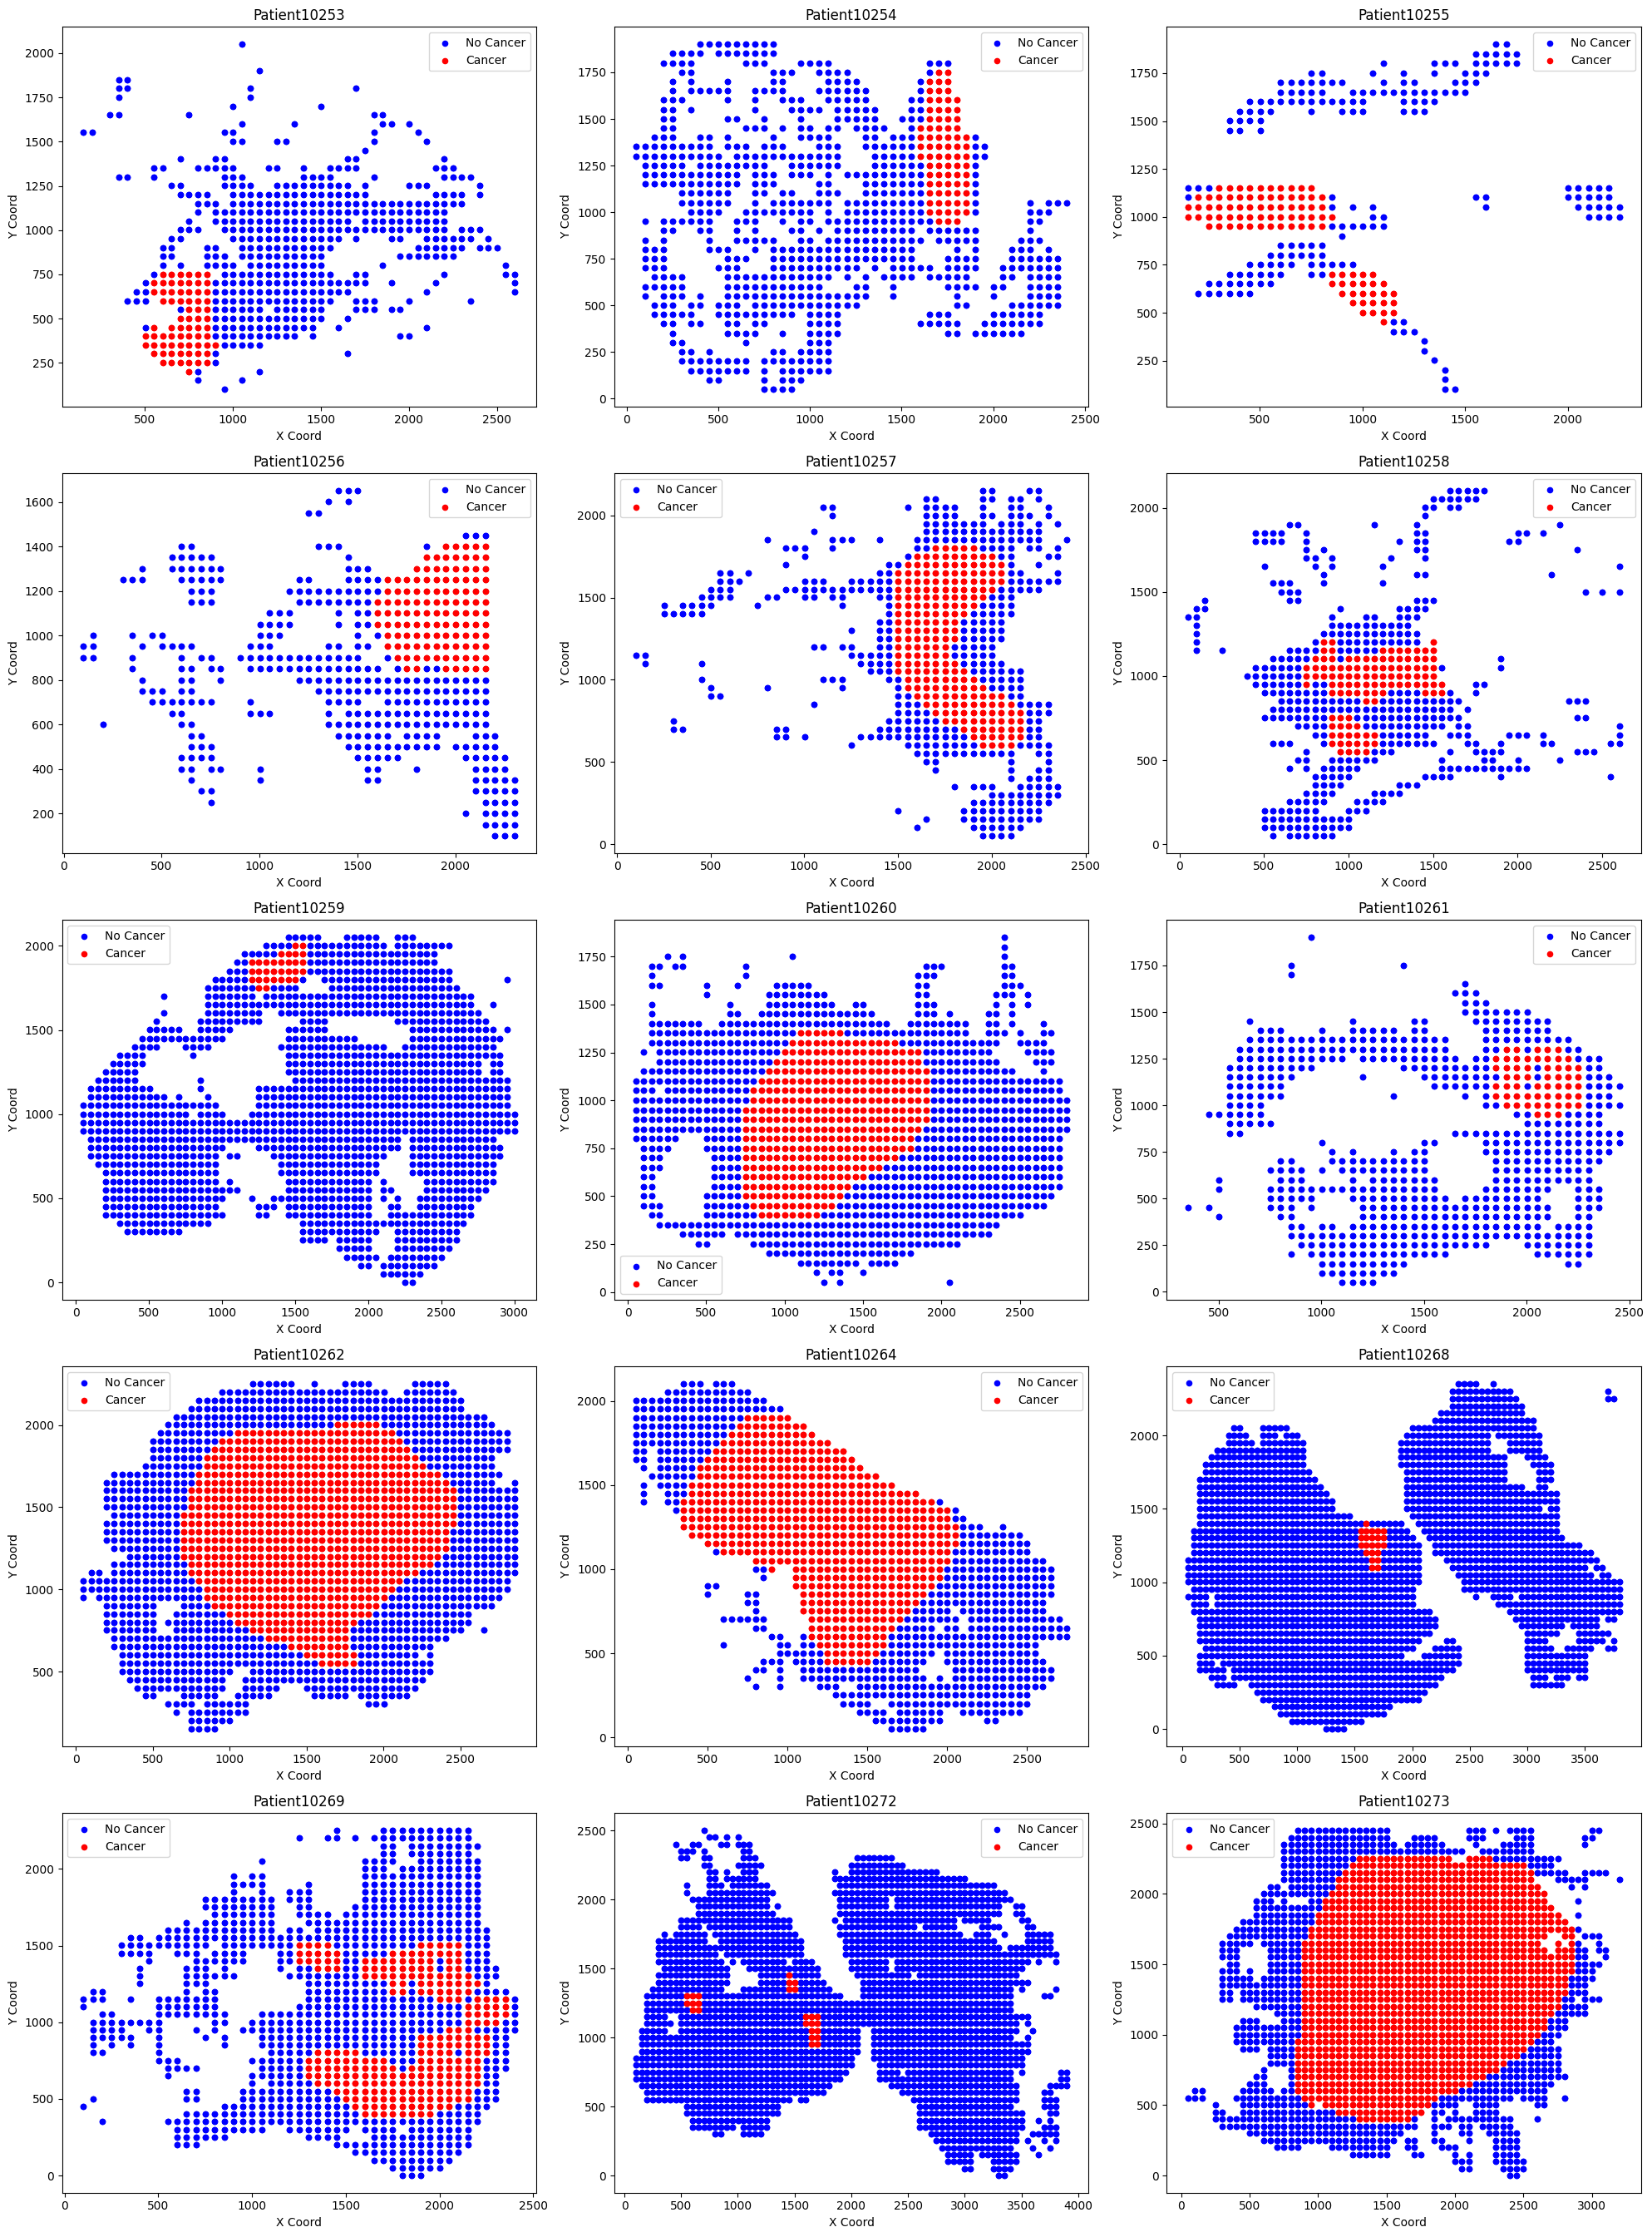

In [16]:
patient_ids = df['Patient_Number'].unique()
fig, axs = plt.subplots(5,3, figsize = (20,27))

for i in range(5):
    for j in range(3):
        if 3 * i + j < len(patient_ids):
            patient_id = patient_ids[3 * i + j]
            patient_df = df[df["Patient_Number"] == patient_id]
            axs[i,j].scatter(patient_df[patient_df['Cancer_Status'] == 0]['X_Coord'], patient_df[patient_df['Cancer_Status'] == 0]['Y_Coord'], c = 'blue', label='No Cancer', s = 20)
            axs[i,j].scatter(patient_df[patient_df['Cancer_Status'] == 1]['X_Coord'], patient_df[patient_df['Cancer_Status'] == 1]['Y_Coord'], c = 'red', label='Cancer', s = 20)
            axs[i,j].set_title('Patient' + str(patient_id))
            axs[i,j].set_xlabel('X Coord')
            axs[i,j].set_ylabel("Y Coord")
            axs[i,j].legend()

plt.tight_layout()
plt.show()

In [17]:
# check image dataframe
for imgname in breast_imgs[:7]:
    print(imgname)

/content/breast-histopathology-images/10304/1/10304_idx5_x601_y851_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x501_y1001_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x451_y651_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x551_y451_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x701_y951_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x451_y601_class1.png
/content/breast-histopathology-images/10304/1/10304_idx5_x551_y851_class1.png


In [18]:
print(df.columns)

Index(['Patient_Number', 'Cancer_Status', 'X_Coord', 'Y_Coord', 'File_Name',
       'File_Path'],
      dtype='object')


In [19]:

# Assuming df is pre-sorted as required.
df['Full_Path'] = df['File_Path']

# Function to load images and coordinates
def load_image_and_coords_from_path(file_path, label, x_coord, y_coord):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3) #decode to an RGB image
    image = tf.image.resize(image, [50, 50])
    return (image, tf.cast(label, tf.float32), tf.cast(x_coord, tf.float32), tf.cast(y_coord, tf.float32)) #return a tuple - processed image, label to 32-bit floating point


# Create a TensorFlow dataset from the DataFrame
def create_dataset(df):

    path_ds = tf.data.Dataset.from_tensor_slices((
        df['Full_Path'].values, # if error below df['Full_Path'].values.astype(str) to ensure string type for paths
        df['Cancer_Status'].values,
        df['X_Coord'].values,
        df['Y_Coord'].values
    ))
    # Use num_parallel_calls=None to ensure that the map operation is deterministic
    dataset = path_ds.map(load_image_and_coords_from_path)
    # Batch the dataset without shuffling
    return dataset.batch(512)

# Function to unpack features and labels
def unpack_features_labels(image, label, x_coord, y_coord):
    return (image, tf.stack([x_coord, y_coord], axis=1)), label

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['Patient_Number'])
valid_df, test_df = train_test_split(temp_df, test_size=(0.05 / 0.15), random_state=42, stratify=temp_df['Patient_Number'])

# Create and unpack datasets ensuring they are ordered
train_dataset = create_dataset(train_df)
train_dataset = train_dataset.map(unpack_features_labels)

valid_dataset = create_dataset(valid_df)
val_dataset  = valid_dataset.map(unpack_features_labels)

test_dataset = create_dataset(test_df)
test_dataset = test_dataset.map(unpack_features_labels)



# Print out the coordinates from the first batch to verify order
for (images, coords), labels in train_dataset.take(1):
    x_coords, y_coords = tf.unstack(coords, axis=1)
    for i in range(tf.shape(labels)[0]):
        print(f'Image {i}: Label: {labels[i].numpy()}, X_Coord: {x_coords[i].numpy()}, Y_Coord: {y_coords[i].numpy()}')

Image 0: Label: 1.0, X_Coord: 1551.0, Y_Coord: 1201.0
Image 1: Label: 1.0, X_Coord: 1601.0, Y_Coord: 2151.0
Image 2: Label: 1.0, X_Coord: 2251.0, Y_Coord: 901.0
Image 3: Label: 0.0, X_Coord: 501.0, Y_Coord: 851.0
Image 4: Label: 0.0, X_Coord: 251.0, Y_Coord: 1801.0
Image 5: Label: 0.0, X_Coord: 1801.0, Y_Coord: 401.0
Image 6: Label: 0.0, X_Coord: 201.0, Y_Coord: 551.0
Image 7: Label: 0.0, X_Coord: 2201.0, Y_Coord: 1551.0
Image 8: Label: 0.0, X_Coord: 251.0, Y_Coord: 651.0
Image 9: Label: 0.0, X_Coord: 751.0, Y_Coord: 1201.0
Image 10: Label: 1.0, X_Coord: 1601.0, Y_Coord: 1101.0
Image 11: Label: 0.0, X_Coord: 1151.0, Y_Coord: 1051.0
Image 12: Label: 0.0, X_Coord: 951.0, Y_Coord: 251.0
Image 13: Label: 1.0, X_Coord: 1901.0, Y_Coord: 1951.0
Image 14: Label: 0.0, X_Coord: 1951.0, Y_Coord: 1051.0
Image 15: Label: 1.0, X_Coord: 2001.0, Y_Coord: 1851.0
Image 16: Label: 1.0, X_Coord: 1801.0, Y_Coord: 1201.0
Image 17: Label: 0.0, X_Coord: 951.0, Y_Coord: 1101.0
Image 18: Label: 0.0, X_Coord: 18

In [20]:
def inspect_dataset_structure(dataset, name="Dataset"):
    """
    Inspect the structure of a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to inspect
        name (str, optional): Name of the dataset for printing. Defaults to "Dataset".
    """
    print(f"\n--- {name} Structure Inspection ---")

    # Take the first batch
    for batch in dataset.take(1):
        # Print overall batch information
        print(f"Batch type: {type(batch)}")
        print(f"Batch length: {len(batch)}")

        # If it's a multi-element tuple
        if isinstance(batch, tuple):
            for i, element in enumerate(batch):
                print(f"\nElement {i}:")
                print(f"  Type: {type(element)}")

                # If it's a tensor, print its properties
                if tf.is_tensor(element):
                    print(f"  Shape: {element.shape}")
                    print(f"  Dtype: {element.dtype}")

                    # Try to print a sample of the data
                    try:
                        print(f"  Sample values: {element.numpy()[:5]}")
                    except Exception as e:
                        print(f"  Could not print sample values: {e}")

        # Break after first batch
        break

    # Additional dataset-level information
    try:
        # Count elements in the dataset
        count = sum(1 for _ in dataset)
        print(f"\nTotal number of elements in the dataset: {count}")
    except Exception as e:
        print(f"\nCould not count dataset elements: {e}")

# Usage example
inspect_dataset_structure(train_dataset, "Train Dataset")
inspect_dataset_structure(val_dataset, "Validation Dataset")
inspect_dataset_structure(test_dataset, "Test Dataset")


--- Train Dataset Structure Inspection ---
Batch type: <class 'tuple'>
Batch length: 2

Element 0:
  Type: <class 'tuple'>

Element 1:
  Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (512,)
  Dtype: <dtype: 'float32'>
  Sample values: [1. 1. 1. 0. 0.]

Total number of elements in the dataset: 922

--- Validation Dataset Structure Inspection ---
Batch type: <class 'tuple'>
Batch length: 2

Element 0:
  Type: <class 'tuple'>

Element 1:
  Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (512,)
  Dtype: <dtype: 'float32'>
  Sample values: [0. 1. 1. 0. 0.]

Total number of elements in the dataset: 109

--- Test Dataset Structure Inspection ---
Batch type: <class 'tuple'>
Batch length: 2

Element 0:
  Type: <class 'tuple'>

Element 1:
  Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (512,)
  Dtype: <dtype: 'float32'>
  Sample values: [0. 1. 0. 0. 0.]

Total number of elements in the dataset: 55


In [21]:
# load image function
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels =3)
    image - tf.image.resize(image, [50, 50])
    return image.numpy()

In [23]:
# get images with coords -- DataFrame and a center index as parameters. This function will get surrounding images around a central point.
def get_surrounding_images_with_coords(df, center_idx):
    center_x = df.iloc[center_idx]['X_Coord']
    center_y = df.iloc[center_idx]['Y_Coord']
    # Creates a list of coordinate pairs for a 4x4 grid centered around the central point. Each grid cell is 50x50 pixels
    patch_coords = [(x,y) for y in range(center_y - 1 * 50, center_y + 3 * 50,  50) for x in range(center_x - 1 * 50, center_x + 3 * 50, 50)]
    # an empty 200x200 (4x50 by 4x50) RGB image array to store the final composite image.
    image_patch = np.zeros((4 * 50, 4 * 50, 3), dtype=np.uint8)
    # empty list to store coordinates, labels, and whether images are original or mirrored.
    used_coords_labels = []
    # Iterates through the coordinate pairs, calculating the row and column position in the 4x4 grid
    for i, (x, y) in enumerate(patch_coords):
        row = i // 4
        col = i % 4
        image_df = df[(df['X_Coord'] == x) & (df['Y_Coord'] == y)]
        # If no image exists at these coordinates:Finds the nearest image using Manhattan distanceLoads that image
        if image_df.empty:
            nearest_idx = ((df['X_Coord'] - x).abs() + (df['Y_Coord'] - y).abs()).argmin()
            nearest_image_df = df.iloc[nearest_idx]
            image = load_image(nearest_image_df['Full_Path'])
            # Flips the image horizontally or vertically based on its position relative to the center.
            if nearest_image_df['X_Coord'] < center_x:
                image = np.fliplr(image)
            elif nearest_image_df['X_Coord'] > center_x:
                image = np.flipud(image)
            # Records that this position used a mirrored image.
            used_coords_labels.append((nearest_image_df['X_Coord'], nearest_image_df['Y_Coord'], nearest_image_df['Cancer_Status'], 'Mirror'))
        else:
            image = load_image(image_df.iloc[0]['Full_Path'])
            used_coords_labels.append((x, y, image_df.iloc[0]['Cancer_Status'], 'Original'))

        # If an image exists at these coordinates, loads it and marks it as original.
        image_patch[row * 50:(row + 1) * 50, col * 50:(col + 1) * 50, :] = image

    # Places the loaded image in the correct position in the composite image.
    green_mask = np.full((50, 50, 3), [0, 255, 0], dtype=np.uint8)
    image_patch[100:150, 100:150, :] = np.clip(image_patch[100:150, 100:150, :] + green_mask * 0.2, 0, 255)

    # Adds a semi-transparent green overlay to the center image in the grid.
    return image_patch, used_coords_labels

# Returns the composite image and the list of coordinates/labels used.
# Calls the function with index 55 as the center image
center_image_idx = 55
patch_image, patch_coords_labels = get_surrounding_images_with_coords(df, center_image_idx)

# Prints the coordinates and labels of all images used, then displays the composite image.
print("Coordinates and labels of the images in the patch:")
for coord_label in patch_coords_labels:
    print(coord_label)


plt.imshow(patch_image)
plt.axis('off')
plt.show()

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a uint8 tensor but is a float tensor [Op:Sub] name: 

In [25]:
def get_surrounding_images_with_coords(df, center_idx):
    center_x = df.iloc[center_idx]['X_Coord']
    center_y = df.iloc[center_idx]['Y_Coord']

    # Creates a list of coordinate pairs for a 4x4 grid centered around the central point
    patch_coords = [(x,y) for y in range(center_y - 1 * 50, center_y + 3 * 50,  50)
                    for x in range(center_x - 1 * 50, center_x + 3 * 50, 50)]

    # Create image patch using NumPy
    image_patch = np.zeros((4 * 50, 4 * 50, 3), dtype=np.uint8)
    used_coords_labels = []

    for i, (x, y) in enumerate(patch_coords):
        row = i // 4
        col = i % 4
        image_df = df[(df['X_Coord'] == x) & (df['Y_Coord'] == y)]

        if image_df.empty:
            nearest_idx = ((df['X_Coord'] - x).abs() + (df['Y_Coord'] - y).abs()).argmin()
            nearest_image_df = df.iloc[nearest_idx]
            image = load_image(nearest_image_df['Full_Path'])

            # Flip logic
            if nearest_image_df['X_Coord'] < center_x:
                image = cv2.flip(image, 1)  # Horizontal flip
            elif nearest_image_df['X_Coord'] > center_x:
                image = cv2.flip(image, 0)  # Vertical flip

            used_coords_labels.append((nearest_image_df['X_Coord'],
                                       nearest_image_df['Y_Coord'],
                                       nearest_image_df['Cancer_Status'],
                                       'Mirror'))
        else:
            image = load_image(image_df.iloc[0]['Full_Path'])
            used_coords_labels.append((x, y, image_df.iloc[0]['Cancer_Status'], 'Original'))

        # Place image in patch
        image_patch[row * 50:(row + 1) * 50, col * 50:(col + 1) * 50, :] = image

    # Create green overlay using pure NumPy operations
    green_overlay = np.zeros_like(image_patch[100:150, 100:150, :], dtype=np.uint8)
    green_overlay[:,:,:] = [0, 255, 0]

    # Blend center patch with green overlay
    center_patch = image_patch[100:150, 100:150, :].astype(np.float32)
    green_overlay = green_overlay.astype(np.float32)

    blended_patch = cv2.addWeighted(center_patch, 0.8, green_overlay, 0.2, 0)
    image_patch[100:150, 100:150, :] = blended_patch.astype(np.uint8)

    return image_patch, used_coords_labels

In [26]:
# CPU and GPU set-up --  colab ()()
USO_TPU = bool(1)
USO_GPU = bool(0)



if USO_TPU:

    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)


if USO_GPU:
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

ValueError: Please provide a TPU Name to connect to.

In [27]:
# code cells above for CPU and GPU set-up work on colab
import tensorflow as tf

USO_TPU = bool(1)  # Set to True if TPU is required
USO_GPU = bool(0)  # Set to True if GPU is required

strategy = None

if USO_TPU:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("TPU initialized successfully.")
    except ValueError as e:
        print("TPU not found. Please ensure TPU runtime is enabled in Colab.")
        strategy = tf.distribute.get_strategy()  # Default strategy for single device

if USO_GPU and not USO_TPU:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")

if strategy is None:
    print("Neither TPU nor GPU is available. Using default strategy.")
    strategy = tf.distribute.get_strategy()


TPU not found. Please ensure TPU runtime is enabled in Colab.


In [28]:
# model build up
import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Add, Resizing, Cropping2D, RandomRotation, RandomBrightness, RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ConvNeXtTiny, NASNetMobile, VGG16, EfficientNetV2M, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, GaussianNoise
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input


In [30]:
# uncomment code if strategy doesn't work
with strategy.scope():
    # input for images 50x50 pixels and 3 channels - RGB
    image_input = Input(shape=(50, 50, 3), name='image_input')
    # input layer for coordinates
    coords_input = Input(shape=(2,), name='coords_input')
    # data augmentation (add image brightness, flip add random noise)
    x = RandomBrightness(0.2)(image_input)
    x = RandomFlip()(x)
    x = GaussianNoise(0.2)(x)
    # preprocess specific to EfficientNetV2M
    processed = preprocess_input(x)
    # load base EfficientNetB3 model
    base_model = EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor=processed)
    # freeze layers of the base model and set as trainable
    for layer in base_model.layers:
        layer.trainable = True
    # flatten output of base model
    flattened_base_model = Flatten()(base_model.output)
    # dense layers
    dense1 = Dense(128, activation='relu')(flattened_base_model)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.1)(batch_norm1)

    dense2 = Dense(64, activation='relu')(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.2)(batch_norm2)

    dense3 = Dense(32, activation='relu')(dropout2)
    batch_norm3 = BatchNormalization()(dense3)

    # output layer
    output = Dense(1, activation='sigmoid')(batch_norm3)

    model = Model(inputs=[image_input, coords_input], outputs=output)

    model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])





In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 50, 50, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_brightness_1       │ (None, 50, 50, 3)      │              0 │ image_input[0][0]      │
│ (RandomBrightness)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_1             │ (None, 50, 50, 3)      │              0 │ random_brightness_1[0… │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_1          │ (None, 50, 50, 3)      │              0 │ random_flip_1[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 50, 50, 3)      │              0 │ gaussian_noise_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 50, 50, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 50, 50, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 51, 51, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 25, 25, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 25, 25, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 25, 25, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 25, 25, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 25, 25, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 25, 25, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze   

 Total params: 11,581,360 (44.18 MB)

 Trainable params: 11,493,609 (43.84 MB)

 Non-trainable params: 87,751 (342.78 KB)

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [33]:
# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True)

In [34]:
# reduce learning rate
plateau = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

In [36]:
# custom learning rate scheduler
from tensorflow.keras.callbacks import Callback

class LRScheduler(Callback):
    def __init__(self, schedule):
        super(LRScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must hae a "lr" attribute.')
        # get current learning rate from model
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # call schedule function to get scheduled learning rate
        scheduled_lr = self.schedule(epoch, lr)
        # set value back to optimizer befor epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"Epoch {epoch+1}: Learning rate is {scheduled_lr}")

    # custom scheduler function
    def lr_scheduler(epoch, lr):
        if epoch < 20:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    # instantiate LRScheduler with function
    lr_scheduler_callback = LRScheduler(lr_scheduler)

    # define class weights if classes are imbalances
    class_weights = {0: 1.0, 1: 5.0}

NameError: name 'LRScheduler' is not defined

In [37]:
# custom learning rate scheduler
from tensorflow.keras.callbacks import Callback

class LRScheduler(Callback):
    def __init__(self, schedule):
        super(LRScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must hae a "lr" attribute.')
        # get current learning rate from model
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # call schedule function to get scheduled learning rate
        scheduled_lr = self.schedule(epoch, lr)
        # set value back to optimizer befor epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"Epoch {epoch+1}: Learning rate is {scheduled_lr}")

# custom scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# instantiate LRScheduler with function outside the class
lr_scheduler_callback = LRScheduler(lr_scheduler)

# define class weights if classes are imbalances
# Note: You had a typo here, it should be '=' instead of '-'
class_weights = {0: 1.0, 1: 5.0}


In [38]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,  # cheza hapa
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, plateau, lr_scheduler_callback])

ValueError: Optimizer must hae a "lr" attribute.

In [ ]:
# plot loss
loss = history.history['loss']
val = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val, label='Validation Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()